In [1]:
import json
from osgeo import gdal
import os
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

gdal.UseExceptions()

FULL_BBOXES_PATH = "../../data/annotations_full/"
CROPPED_BBOXES_PATH = "../../data/annotations_cropped/"
FULL_IMAGES_PATH = "../../data/images_full/"
CROPPED_IMAGES_PATH = "../../data/images_cropped/"

# Create the output directories if they doesn't exist
if not os.path.exists(CROPPED_BBOXES_PATH):
    os.makedirs(CROPPED_BBOXES_PATH)
if not os.path.exists(CROPPED_IMAGES_PATH):
    os.makedirs(CROPPED_IMAGES_PATH)

In [2]:
# Define tile size and OVERLAP
TILE_SIZE = 1920  # Size of each tile
OVERLAP = 480  # Overlap between tiles

In [8]:
bboxes_path = FULL_BBOXES_PATH + "3"

with open(bboxes_path, "r") as file:
    # Load the annotation data
    bboxes_json = json.load(file)
    
    # Get the path to the full image
    full_image_path = bboxes_json["task"]["data"]["image"].replace("/data/local-files/?d=", "/")
    full_image_path_tif = full_image_path.replace(".png", ".tif")
    
    # Get the dimensions of the full image
    full_image = Image.open(full_image_path)
    full_image_width, full_image_height = full_image.size
    full_image_width_factor, full_image_height_factor = full_image_width / 100., full_image_height / 100.
    
    # Create the path
    output_image_prefix = os.path.splitext(os.path.basename(full_image_path_tif))[0]
    annotation_output_directory = os.path.join(CROPPED_BBOXES_PATH, output_image_prefix)
    if not os.path.exists(annotation_output_directory):
        os.makedirs(annotation_output_directory)
    
    # Calculate the number of rows and columns needed
    num_cols = int(np.ceil((full_image_width - OVERLAP) / (TILE_SIZE - OVERLAP)))
    num_rows = int(np.ceil((full_image_height - OVERLAP) // (TILE_SIZE - OVERLAP)))
    
    # Get the limits of all the cropped images
    cropping_limits_x = np.array([[i*(TILE_SIZE - OVERLAP), (i+1)*(TILE_SIZE - OVERLAP) + OVERLAP] for i in range(num_cols)])
    cropping_limits_y = np.array([[j*(TILE_SIZE - OVERLAP), (j+1)*(TILE_SIZE - OVERLAP) + OVERLAP] for j in range(num_rows)])
    
    bboxes_repartition = [[[] for _ in range(num_rows)] for _ in range(num_cols)]
    count = 0
    for index, bbox_info in enumerate(bboxes_json["result"]):
        bbox = bbox_info["value"]
        min_x = int(np.round(bbox["x"] * full_image_width_factor))
        min_y = int(np.round(bbox["y"] * full_image_height_factor))
        max_x = int(np.round((bbox["x"] + bbox["width"]) * full_image_width_factor))
        max_y = int(np.round((bbox["y"] + bbox["height"]) * full_image_height_factor))
        # Find the indices of the cropped images in which the bounding box fits
        i_x_0 = min_x // (TILE_SIZE - OVERLAP)
        i_y_0 = min_y // (TILE_SIZE - OVERLAP)
        
        found_image = False # To check if the bounding box fits entirely in at least one cropped image
        
        # Check the 4 possibilities
        if (max_x < (i_x_0+1)*(TILE_SIZE - OVERLAP) + OVERLAP):
            # First possible image (bottom right)
            if (max_y < (i_y_0+1)*(TILE_SIZE - OVERLAP) + OVERLAP):
                bboxes_repartition[i_x_0][i_y_0].append(index)
                found_image = True
            # Second possible image (top right)
            if (max_y < (i_y_0)*(TILE_SIZE - OVERLAP) + OVERLAP):
                bboxes_repartition[i_x_0][i_y_0-1].append(index)
                found_image = True
        if (max_x < (i_x_0)*(TILE_SIZE - OVERLAP) + OVERLAP):
            # Third possible image (bottom left)
            if (max_y < (i_y_0+1)*(TILE_SIZE - OVERLAP) + OVERLAP):
                bboxes_repartition[i_x_0-1][i_y_0].append(index)
                found_image = True
            # Fourth possible image (top left)
            if (max_y < (i_y_0)*(TILE_SIZE - OVERLAP) + OVERLAP):
                bboxes_repartition[i_x_0-1][i_y_0-1].append(index)
                found_image = True
        
        if (not found_image):
            raise Exception(f"The bounding box at index {index} doesn't fit entirely in any image.")
        
    # Create and store the cropped annotation files
    for row in tqdm(range(num_rows)):
        for col in tqdm(range(num_cols), leave=False):
            bboxes_dict = {
                "full_image": {
                    "path": full_image_path_tif,
                    "coordinates_of_cropped_image": {
                        "x": col*(TILE_SIZE - OVERLAP),
                        "y": row*(TILE_SIZE - OVERLAP),
                        "width": TILE_SIZE,
                        "height": TILE_SIZE,
                    },
                    "overlap": OVERLAP,
                },
                "col": col,
                "row": row,
                "width": TILE_SIZE,
                "height": TILE_SIZE,
                "bounding_boxes": [{
                        "id": bboxes_json["result"][i]["id"],
                        "index": i,
                        "x": bboxes_json["result"][i]["value"]["x"] * full_image_width_factor - col * (TILE_SIZE - OVERLAP),
                        "y": bboxes_json["result"][i]["value"]["y"] * full_image_width_factor - row * (TILE_SIZE - OVERLAP),
                        "width": bboxes_json["result"][i]["value"]["width"] * full_image_width_factor,
                        "height": bboxes_json["result"][i]["value"]["height"] * full_image_width_factor,
                        "label": bboxes_json["result"][i]["value"]["rectanglelabels"][0],
                } for i in bboxes_repartition[col][row]]
            }
            
            annotation_output_filename = f"{output_image_prefix}_{row}_{col}.json"
            output_path = os.path.join(annotation_output_directory, annotation_output_filename)
            with open(output_path, "w") as outfile: 
                json.dump(bboxes_dict, outfile)

/home/alexandre/miniforge3/envs/tree-segment/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (156250000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [4]:
# All this can also be done using gdal_retile.py

# Define output paths
image_output_directory = os.path.join(CROPPED_IMAGES_PATH, output_image_prefix)
if not os.path.exists(image_output_directory):
    os.makedirs(image_output_directory)

# Iterate over rows and columns to create tiles
for row in tqdm(range(num_rows)):
    for col in tqdm(range(num_cols), leave=False):
        # Calculate the pixel offsets for the tile
        x_offset = col * (TILE_SIZE - OVERLAP)
        y_offset = row * (TILE_SIZE - OVERLAP)

        # Create output filename
        output_filename = f"{output_image_prefix}_{row}_{col}.tif"
        output_path = os.path.join(image_output_directory, output_filename)

        # Define the subset area to read from the input image
        window = (x_offset, y_offset, TILE_SIZE, TILE_SIZE)

        gdal.Translate(output_path, full_image_path_tif, srcWin=window)

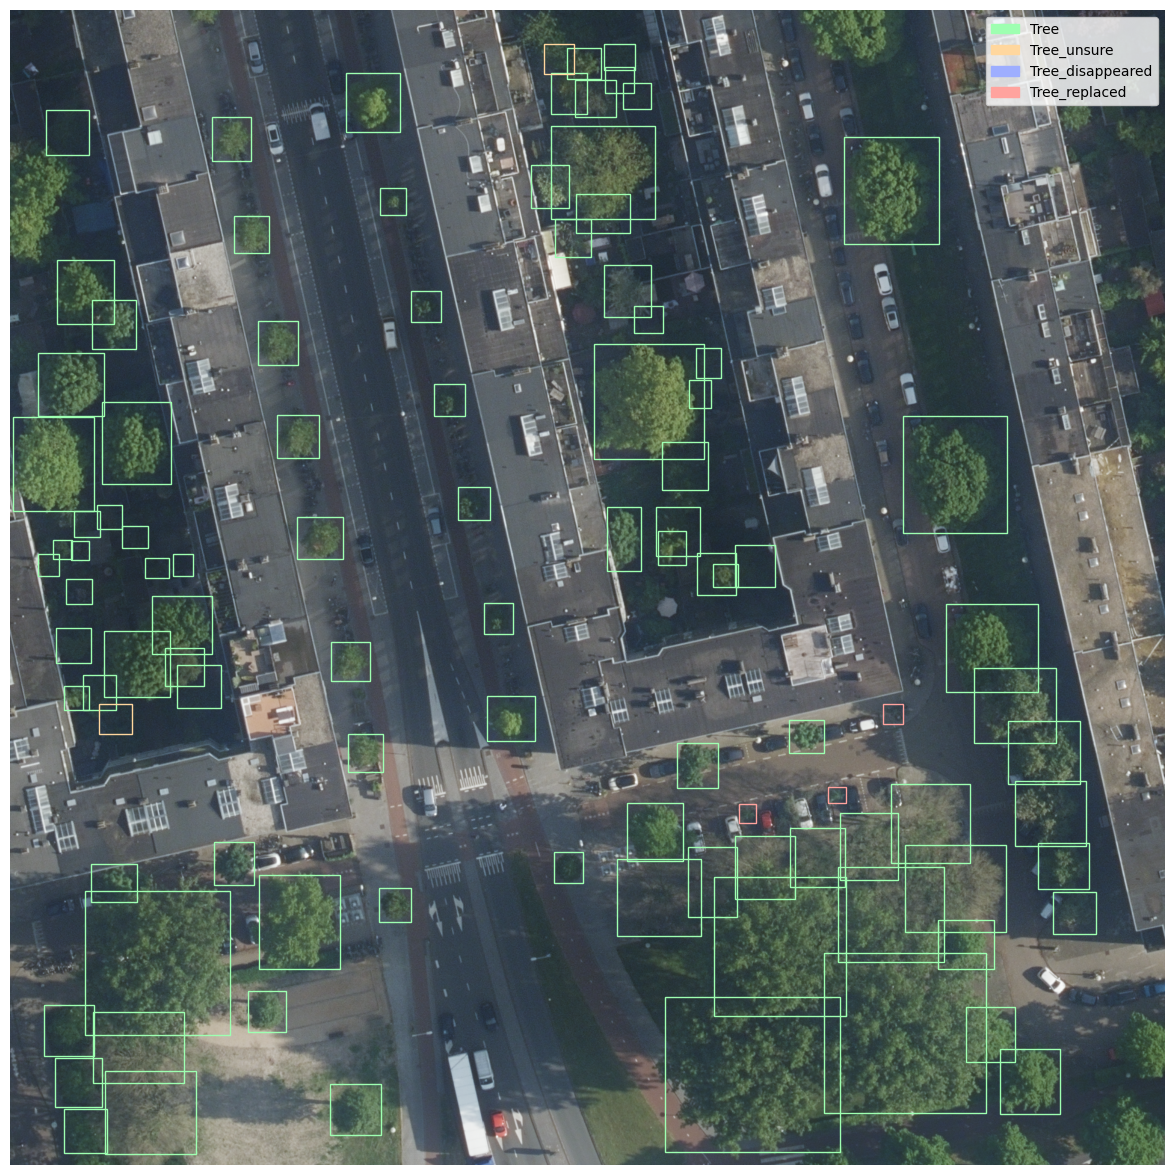

In [20]:
def display_image_with_boxes(image_path: str, boxes: list | None=None) -> None:
    # Load image
    image = plt.imread(image_path)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15,15))
    
    # Display image
    ax.imshow(image)
    
    # Annotation colors
    colors = {
        "Tree": "#9effb1",
        "Tree_unsure": "#ffd79e",
        "Tree_disappeared": "#9eaeff",
        "Tree_replaced": "#ffa39e",
    }
    
    # Add bounding boxes if provided
    if boxes:
        for box in boxes:
            # Extract box coordinates
            x, y, width, height, label = box
            # Create a Rectangle patch
            rect = Rectangle((x, y), width, height, linewidth=1, edgecolor=colors[label], facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)
    
    # Add each rectangle to the legend individually
    for label, color in colors.items():
        ax.add_patch(Rectangle((0,0), 0, 0, color=color, label=label))
    
    ax.set_axis_off()
    ax.legend()
    
    # Show plot
    plt.show()
    
def get_bounding_boxes(bboxes_path: str) -> list:
    with open(bboxes_path, "r") as file:
        # Load the annotation data
        bboxes_json = json.load(file)
        
        # Get every bounding box
        bboxes = []
        for bbox in bboxes_json["bounding_boxes"]:
            bboxes.append((bbox["x"], bbox["y"], bbox["width"], bbox["height"], bbox["label"]))
            
    return bboxes

image_path = "../../data/images_cropped/2023_122000_484000_RGB_hrl/2023_122000_484000_RGB_hrl_1_2.tif"
bboxes_path = "../../data/annotations_cropped/2023_122000_484000_RGB_hrl/2023_122000_484000_RGB_hrl_1_2.json"

bboxes = get_bounding_boxes(bboxes_path)
display_image_with_boxes(image_path, bboxes)